# 多目标跟踪



其中就是先定位到个人，然后对个人进行跟踪，这是来自项目：[Smorodov/Multitarget-tracker](https://github.com/Smorodov/Multitarget-tracker)的一则检测结果，看着很酷炫的样子。
那么，其中是一种比较简单的多目标追踪方式：detector+tracker，两者其实是相对独立的。
![在这里插入图片描述](https://img-blog.csdnimg.cn/20190119220546619.?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3NpbmF0XzI2OTE3Mzgz,size_16,color_FFFFFF,t_70)
这是笔者画的一个草图，这里的流程就是，图片经过detector，得到人体坐标框，然后计算中心点位置centers（x0,y0），将该centers（x0,y0）输入给追踪器，追踪器去学习（Update）并给出预测。


In [9]:
#from tracker import Tracker
import copy
import colorsys
import os,sys,argparse,random
from timeit import default_timer as timer
import cv2
import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
from keras.utils import multi_gpu_model
from yolo_matt import YOLO, detect_video

from tqdm import tqdm
from scipy import misc

%matplotlib inline 
from matplotlib import pyplot as plt

from objecttracker.KalmanFilterTracker import Tracker  # 加载卡尔曼滤波函数

def calc_center(out_boxes,out_classes,out_scores,score_limit = 0.5):
    outboxes_filter = []
    for x,y,z in zip(out_boxes,out_classes,out_scores):
        if z > score_limit:
            if y == 0: # person标签为0
                outboxes_filter.append(x)
    
    centers= []
    number = len(outboxes_filter)
    for box in outboxes_filter:
        top, left, bottom, right = box
        center=np.array([[(left+right)//2],[(top+bottom)//2]])
        centers.append(center)
    return centers,number


def get_colors_for_classes(num_classes):
    """Return list of random colors for number of classes given."""
    # Use previously generated colors if num_classes is the same.
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    #colors = [(255,99,71) if c==(255,0,0) else c for c in colors ]  # 单独修正颜色，可去除
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    get_colors_for_classes.colors = colors  # Save colors for future calls.
    return colors

def trackerDetection(tracker,image,centers,number,max_point_distance = 30,max_colors = 20,track_id_size = 0.8):
    '''
        - max_point_distance为两个点之间的欧式距离不能超过30
            - 有多条轨迹,tracker.tracks;
            - 每条轨迹有多个点,tracker.tracks[i].trace
        - max_colors,最大颜色数量
        - track_id_size,每个中心点，显示的标记字体大小
    '''
    #track_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
    #            (0, 255, 255), (255, 0, 255), (255, 127, 255),
    #            (127, 0, 255), (127, 0, 127)]
    track_colors = get_colors_for_classes(max_colors)
    
    result = np.asarray(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, str(number), (20,  40), font, 1, (0, 0, 255), 5)  # 左上角，人数计数

    if (len(centers) > 0):
        # Track object using Kalman Filter
        tracker.Update(centers)
        # For identified object tracks draw tracking line
        # Use various colors to indicate different track_id
        for i in range(len(tracker.tracks)):
            # 多个轨迹
            if (len(tracker.tracks[i].trace) > 1):
                x0,y0 = tracker.tracks[i].trace[-1][0][0],tracker.tracks[i].trace[-1][1][0]
                cv2.putText(result,str(tracker.tracks[i].track_id),(int(x0),int(y0)),font,track_id_size,(255, 255, 255),4)  
                # (image,text,(x,y),font,size,color,粗细)
                for j in range(len(tracker.tracks[i].trace) - 1):
                    #每条轨迹的每个点
                    # Draw trace line
                    x1 = tracker.tracks[i].trace[j][0][0]
                    y1 = tracker.tracks[i].trace[j][1][0]
                    x2 = tracker.tracks[i].trace[j + 1][0][0]
                    y2 = tracker.tracks[i].trace[j + 1][1][0]
                    clr = tracker.tracks[i].track_id % 9
                    distance = ((x2 - x1)** 2 + (y2 - y1)**2)**0.5
                    if distance <  max_point_distance:
                        cv2.line(result, (int(x1), int(y1)), (int(x2), int(y2)),
                                 track_colors[clr], 4)
    return tracker,result


In [2]:
# 加载keras yolov3 voc预训练模型
yolo_test_args = {
    "model_path": 'model_data/yolo.h5',
    "anchors_path": 'model_data/yolo_anchors.txt',
    "classes_path": 'model_data/coco_classes.txt',
    "score" : 0.3,
    "iou" : 0.45,
    "model_image_size" : (416, 416),
    "gpu_num" : 1,
}


yolo_test = YOLO(**yolo_test_args)

model_data/yolo.h5 model, anchors, and classes loaded.


(416, 416, 3)
Found 2 boxes for img
person 0.80 (187, 562) (248, 711)
person 0.93 (109, 545) (183, 684)
0.0905019361525774


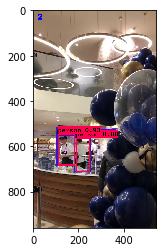

In [19]:
'''
    解析方式一： 从视频保存成的图像文件中进行解析
    先把视频-> 拆分成图像文件夹，在文件夹中逐帧解析
'''

tracker = Tracker(100, 8, 15, 100)
#for n in tqdm(range(100)):
image = Image.open('11.jpg')
r_image,out_boxes, out_scores, out_classes = yolo_test.detect_image(image)
centers,number = calc_center(out_boxes,out_classes,out_scores,score_limit = 0.5)
tracker,result = trackerDetection(tracker,r_image,centers,number,max_point_distance = 30,max_colors = 20,track_id_size = 2)
#misc.imsave('jpg2video/%s.jpg'%n, result)
plt.imshow(result)

In [ ]:
'''
    解析方式二：视频流直接解析    
    直接读取视频流，并保存在某一个文件夹之中
'''
# 视频 -> 图像
path = "grom.mp4"
tracker = Tracker(100, 8, 15, 100)

cap = cv2.VideoCapture(path)
n = 0
while(True):
    ret, frame = cap.read()
    if frame is None:
        break
    image = Image.fromarray(frame ) 
    r_image,out_boxes, out_scores, out_classes = yolo_test.detect_image(image)
    centers,number = calc_center(out_boxes,out_classes,out_scores,score_limit = 0.6)
    tracker,result = trackerDetection(tracker,r_image,centers,number,max_point_distance = 20)
    #misc.imsave('%s.jpg'%n, result)
    cv2.imwrite('%s.jpg'%n,result, [int(cv2.IMWRITE_JPEG_QUALITY), 100] )
    n += 1
print('Down!')